In [88]:
%reset -f
import numpy as np
import sys
sys.path.insert(0,'..')
from wavhandler import *
import math
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from utils_train import train_test_val_split, TrainConfiguration, test_inds, test_days, train_generator, valid_generator

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.layers import Conv1D, GlobalAveragePooling1D, MaxPooling1D
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import BatchNormalization,Input, LSTM, GRU
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger
from tensorflow.keras.utils import to_categorical

np.random.seed(42)

In [89]:
def train_test_filenames(dataset, species, train_dates=[], test_dates=[], plot=True):

    dataset.read(species, loadmat=False)
    dataset.get_sensor_features()
    sub = dataset.df_features
    if plot:
        import matplotlib.pyplot as plt
        plt.figure()
        sub.groupby('datestr')['filenames'].count().plot(kind="bar")
    print(sub['datestr'].unique().tolist())

    test_fnames = sub[sub.datestr.isin(test_dates)].filenames
    if len(train_dates): # if train dates are given
        train_fnames = sub[sub.datestr.isin(train_dates)].filenames
    else:
        train_fnames = sub[~sub.datestr.isin(test_dates)].filenames

    print("{} train filenames, {} test filenames".format(train_fnames.shape[0], test_fnames.shape[0]))
    return train_fnames, test_fnames


In [90]:
# from IPython.core.display import Image, display

# PATH = "./temp_data/"
# Image(filename = PATH + "split.png", width=800, height=800)

In [91]:
splitting = 'custom' # 'random'
data_setting = 'raw' # stft
model_setting = 'CONV1D' # lstm

assert splitting in ['random','randomcv','custom'], "Wrong splitting method given."
assert data_setting in ['raw','stft', "Wrong data settting given."]
assert model_setting in ['wavenet','lstm','gru','LSTM','GRU','CONV1D','CONV2D','conv1d','conv2d']

In [92]:
data = Dataset('Wingbeats')
print(data.target_classes)

['Ae. aegypti', 'Ae. albopictus', 'An. arabiensis', 'An. gambiae', 'C. pipiens', 'C. quinquefasciatus']


SPLITTING DATA custom
Species: Ae. aegypti.
Read 85553 filenames in 1.85 seconds.
['20170211', '20170206', '20170207', '20170212', '20170208', '20170209', '20170210', '20170213', '20161213', '20161212']
82989 train filenames, 2564 test filenames
Species: Ae. albopictus.
Read 20231 filenames in 1.98 seconds.
['20170228', '20170103', '20170301', '20170227', '20170102']
17440 train filenames, 2791 test filenames
Species: An. arabiensis.
Read 19297 filenames in 1.99 seconds.
['20170313', '20170205', '20170319', '20170201', '20170316', '20170315', '20170203', '20170320', '20170318', '20170204', '20170202', '20170314', '20170130', '20170131', '20170206', '20170317']
14207 train filenames, 5090 test filenames
Species: An. gambiae.
Read 49471 filenames in 2.00 seconds.
['20170110', '20170109', '20170119', '20170117', '20170116', '20170121', '20170120', '20170123', '20170118', '20170122']
45471 train filenames, 4000 test filenames
Species: C. quinquefasciatus.
Read 74599 filenames in 1.82 secon

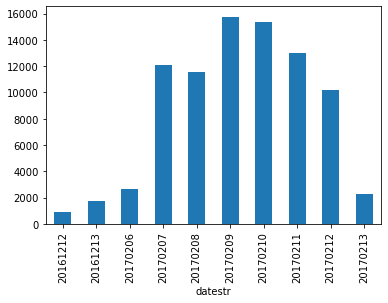

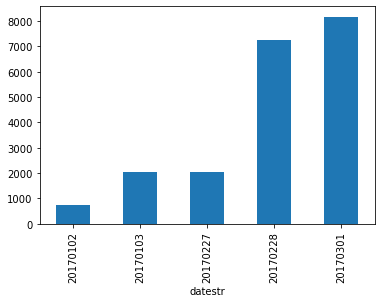

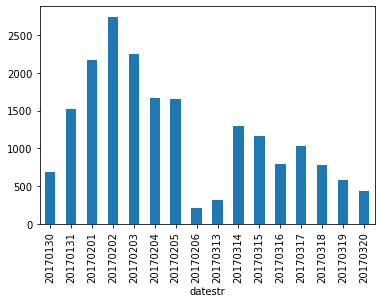

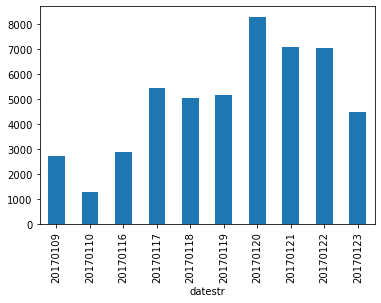

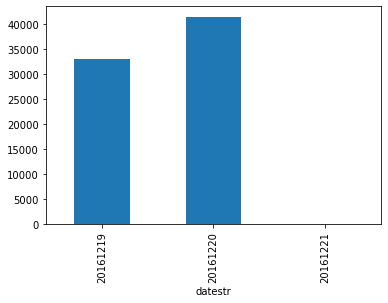

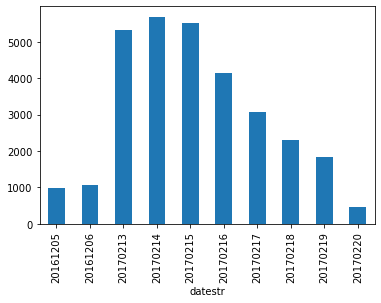

In [210]:
print(f'SPLITTING DATA {splitting}')
# ### Ae. Aegypti
x1_tr, x1_ts = train_test_filenames(data,'Ae. aegypti', test_dates=['20161213','20161212'])
# ### Ae. albopictus
x2_tr, x2_ts = train_test_filenames(data,'Ae. albopictus', test_dates=['20170103', '20170102'])
# ### An. arabiensis
x3_tr, x3_ts = train_test_filenames(data,'An. arabiensis', test_dates=['20170319','20170320',                                                                                            '20170205','20170206','20170131','20170130'])
# ### An. gambiae
x4_tr, x4_ts = train_test_filenames(data,'An. gambiae', test_dates=['20170110', '20170109']) 
# ### Culex quinquefasciatus
x5_tr, x5_ts = train_test_filenames(data,'C. quinquefasciatus', test_dates=['20161219']) 
# ### Culex pipiens
x6_tr, x6_ts = train_test_filenames(data,'C. pipiens', test_dates=['20161206', '20161205']) 

x1_tr, x1_ts = x1_tr.sample(12800), x1_ts.sample(2000)
x2_tr, x2_ts = x2_tr.sample(12800), x2_ts.sample(2000)
x3_tr, x3_ts = x3_tr.sample(12800), x3_ts.sample(2000)
x4_tr, x4_ts = x4_tr.sample(12800), x4_ts.sample(2000)
x5_tr, x5_ts = x5_tr.sample(12800), x5_ts.sample(2000)
x6_tr, x6_ts = x6_tr.sample(12800), x6_ts.sample(2000)

# ## Creating TRAIN/VAL/TEST sets
X_train = pd.concat([x1_tr, x2_tr, x3_tr, x4_tr, x5_tr, x6_tr], axis=0)
X_test = pd.concat([x1_ts, x2_ts, x3_ts, x4_ts, x5_ts, x6_ts], axis=0)

y_train = X_train.apply(lambda x: x.split('/')[len(BASE_DIR.split('/'))])
y_test = X_test.apply(lambda x: x.split('/')[len(BASE_DIR.split('/'))])

le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.fit_transform(y_test)

X_test = X_test.tolist()

# X_train,y_train = shuffle(X_train.tolist(),y_train.tolist(), random_state=0)
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

In [211]:
import itertools

# Creating DataFrame to sort data by date
df = pd.DataFrame(X_train)
df['class'] = df['filenames'].apply(lambda x: x.split('/')[6])
df['wavnames'] = df['filenames'].apply(lambda x: x.split('/')[-1][:-4])
df['date'] = df['wavnames'].apply(lambda x: pd.to_datetime(''.join(x.split('_')[0:2]),                                                             format='F%y%m%d%H%M%S'))
df.sort_values(by='date', inplace=True)

# For each mosquito we divide its data in 5 chunks
classes = df['class'].unique().tolist()
n_chunks = 5 # also number of folds
class_chunks = {} # this is a dict with class as index and 5 lists in each class, 1 for each chunk
for cl, sub in df.groupby('class'):
    sub.reset_index(drop=True, inplace=True) # resetting index to have values from 1....sub.shape[0]    
    lst = list(range(0,sub.shape[0])) # this is basically the index
    n = int(sub.shape[0] / n_chunks) # number of items in each chunk
    inds_chunk = [np.array(lst[i:i + n]) for i in range(0, len(lst), n)] # splitting the index numbers (lst) in 5 chunks
    class_chunks[cl] = [sub.iloc[inds_chunk[j]]['filenames'].tolist() for j in range(len(inds_chunk))] 

# Now creating the actual folds for Cross validation 
X_folds = {} 
y_folds = {}
# For each fold, we add the corresponding chunks of each mosquito
# This means that in FOLD-0 we will have the first chunk of each mosquito
# in FOLD-1 we will have the second chunk of each mosquito etc..
for i in range(n_chunks): 
    X_folds[i] = [] # creating a list in which to add data of each mosquito
    for c in classes: 
        X_folds[i].extend(class_chunks[c][i]) # adding each mosquito chunk data in the list
    y_folds[i] = pd.Series(X_folds[i]).apply(lambda x: x.split('/')[6]).tolist() # targets

# Creating groups to use the LeaveOneGroupOut of sklearn for combining
# our X_folds so that 4 of them become train and 1 becomes val each time.
groups = np.array(range(len(X_folds)))


logo = LeaveOneGroupOut()
for train_index, val_index in logo.split(X_folds, y_folds, groups):
    print(train_index, val_index)

    train_groups = [X_folds.get(key) for key in train_index]
    X_train = list(itertools.chain.from_iterable(zz))
    X_val = X_folds[val_index[0]]

[1 2 3 4] [0]
[0 2 3 4] [1]
[0 1 3 4] [2]
[0 1 2 4] [3]
[0 1 2 3] [4]


[1 2 3 4] [0]
[0 2 3 4] [1]
[0 1 3 4] [2]
[0 1 2 4] [3]
[0 1 2 3] [4]


0

In [19]:
# PRINTING THE CLASS BALANCE
keys = pd.Series(le.inverse_transform(y_train)).value_counts().index.tolist()
values = pd.Series(y_train).value_counts().index.tolist()
mapping = dict(zip(keys, values))
print(sorted(mapping.items(), key=lambda x: x[1]))
vcounts = pd.Series(y_train).value_counts()
vcounts.index = mapping.keys()
print(vcounts)

[('Ae. aegypti', 0), ('Ae. albopictus', 1), ('An. arabiensis', 2), ('An. gambiae', 3), ('C. pipiens', 4), ('C. quinquefasciatus', 5)]
C. pipiens             10344
Ae. aegypti            10265
An. gambiae            10259
An. arabiensis         10231
Ae. albopictus         10184
C. quinquefasciatus    10157
dtype: int64


In [20]:
# MODELLING
from tensorflow.keras.applications.densenet import DenseNet121, DenseNet169, DenseNet201
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.applications.nasnet import NASNetLarge, NASNetMobile
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.xception import Xception

# current_model = DenseNet121
#current_model = DenseNet169
current_model = DenseNet201
#current_model = InceptionResNetV2
#current_model = InceptionV3
#current_model = MobileNet
#current_model = NASNetLarge
#current_model = NASNetMobile
#current_model = VGG16
#current_model = VGG19
#current_model = Xception

traincf = TrainConfiguration(X=X_train, y=y_train, setting=data_setting, model_name=f'{splitting}_{data_setting}_{model_setting}')
targets = 6

print(f'### MODEL NAME ==== {traincf.model_name} ####')

if model_setting in ['gru','GRU','LSTM','lstm']:
    # Build the Neural Network
    model = Sequential()

    model.add(Conv1D(16, 3, activation='relu', input_shape=(5000, 1)))
    model.add(Conv1D(16, 3, activation='relu'))
    model.add(BatchNormalization())

    model.add(Conv1D(32, 3, activation='relu'))
    model.add(Conv1D(32, 3, activation='relu'))
    model.add(BatchNormalization())

    model.add(MaxPooling1D(2))
    model.add(Conv1D(64, 3, activation='relu'))
    model.add(Conv1D(64, 3, activation='relu'))
    model.add(BatchNormalization())

    model.add(MaxPooling1D(2))
    model.add(Conv1D(128, 3, activation='relu'))
    model.add(Conv1D(128, 3, activation='relu'))
    model.add(BatchNormalization())

    model.add(MaxPooling1D(2))
    model.add(Conv1D(256, 3, activation='relu'))
    model.add(Conv1D(256, 3, activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(2))
    if model_setting == 'gru':
        model.add(GRU(units= 128, return_sequences=True))
        model.add(GRU(units=128, return_sequences=False))
    if model_setting == 'lstm':
        model.add(LSTM(units=128, return_sequences=True))
        model.add(LSTM(units=128, return_sequences=False))
    model.add(Dropout(0.5))
    model.add(Dense(targets, activation='softmax'))
elif model_setting == 'CONV2D':
    current_model = DenseNet121
    model = current_model(input_tensor = Input(shape = (129, 120, 1)), 
                        classes = len(traincf.target_names), 
                        weights = None)
elif model_setting == 'wavenet':
    model=Sequential()
    model.add(Conv1D(16, 3, activation='relu', input_shape=(5000, 1)))
    for rate in (1,2,4,8)*2:
        model.add(Conv1D(filters=16*rate,
                                    kernel_size=3,
                                    padding="causal",
                                    activation="relu",
                                    dilation_rate=rate))
        model.add(Conv1D(filters=16*rate,
                                    kernel_size=3,
                                    padding="causal",
                                    activation="relu",
                                    dilation_rate=rate))
        model.add(BatchNormalization())

    model.add(MaxPooling1D(2))
    model.add(Conv1D(128, 2, activation='relu'))
    model.add(Conv1D(128, 2, activation='relu'))
    model.add(BatchNormalization())

    model.add(MaxPooling1D(2))
    model.add(Conv1D(256, 2, activation='relu'))
    model.add(Conv1D(256, 2, activation='relu'))
    model.add(BatchNormalization())
    model.add(GlobalAveragePooling1D())

    model.add(Dropout(0.5))
    model.add(Dense(targets, activation='softmax'))

elif model_setting == 'CONV1D':
    # Build the Neural Network
    model = Sequential()

    model.add(Conv1D(16, 3, activation='relu', input_shape=(5000, 1)))
    model.add(Conv1D(16, 3, activation='relu'))
    model.add(BatchNormalization())

    model.add(Conv1D(32, 3, activation='relu'))
    model.add(Conv1D(32, 3, activation='relu'))
    model.add(BatchNormalization())

    model.add(MaxPooling1D(2))
    model.add(Conv1D(64, 3, activation='relu'))
    model.add(Conv1D(64, 3, activation='relu'))
    model.add(BatchNormalization())

    model.add(MaxPooling1D(2))
    model.add(Conv1D(128, 3, activation='relu'))
    model.add(Conv1D(128, 3, activation='relu'))
    model.add(BatchNormalization())

    model.add(MaxPooling1D(2))
    model.add(Conv1D(256, 3, activation='relu'))
    model.add(Conv1D(256, 3, activation='relu'))
    model.add(BatchNormalization())
    model.add(GlobalAveragePooling1D())

    model.add(Dropout(0.5))
    model.add(Dense(targets, activation='softmax'))
else:
    raise ValueError("Wrong model setting given.")

model.compile(loss='categorical_crossentropy',
            optimizer='adam',
            metrics=['accuracy'])

callbacks_list = traincf.callbacks_list

### MODEL NAME ==== improved_raw_CONV1D ####


In [ ]:
model.fit_generator(train_generator(X_train, y_train, batch_size=traincf.batch_size,
                                   target_names=traincf.target_names,
                                   setting=traincf.setting),
                   steps_per_epoch = int(math.ceil(float(len(X_train)) / float(traincf.batch_size))),
                   epochs=traincf.epochs,
                   validation_data = valid_generator(X_val, y_val,
                                                    batch_size=traincf.batch_size,
                                                    target_names=traincf.target_names,
                                                    setting=traincf.setting),
                    validation_steps=int(math.ceil(float(len(X_test))/float(traincf.batch_size))),
                    callbacks = traincf.callbacks_list)

In [ ]:
model.load_weights(traincf.top_weights_path)
y_pred = model.predict_generator(valid_generator(X_test, 
                                                    y_test, 
                                                    batch_size=traincf.batch_size, 
                                                    setting=traincf.setting, 
                                                    target_names=traincf.target_names),
        steps = int(math.ceil(float(len(X_test)) / float(traincf.batch_size))))

from sklearn.metrics import confusion_matrix
x = confusion_matrix(np.array(y_test), np.argmax(y_pred, axis=1))
print(x)

model.load_weights(traincf.top_weights_path)
loss, acc = model.evaluate_generator(valid_generator(X_test, 
                                                    y_test, 
                                                    batch_size=traincf.batch_size, 
                                                    setting=traincf.setting, 
                                                    target_names=traincf.target_names),
        steps = int(math.ceil(float(len(X_test)) / float(traincf.batch_size))))

print('loss', loss)
print('Test accuracy:', acc)

print(f'### MODEL NAME ==== {traincf.model_name} ####')

from sklearn.metrics import balanced_accuracy_score
print('Balanced accuracy:')
print(balanced_accuracy_score(np.array(y_test), np.argmax(y_pred, axis=1)))
